In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../scripts")

In [3]:
# Main
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils

# Modelling
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import pmdarima as pm
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

In [4]:
plt.rcParams["figure.figsize"] = (14,4)

In [5]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [6]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


In [7]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [8]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


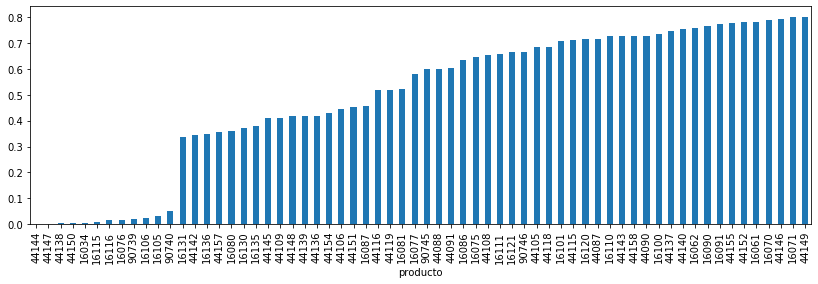

In [9]:
amount_info = utils.get_amount_info(u_producto)
amount_info.plot(kind="bar")

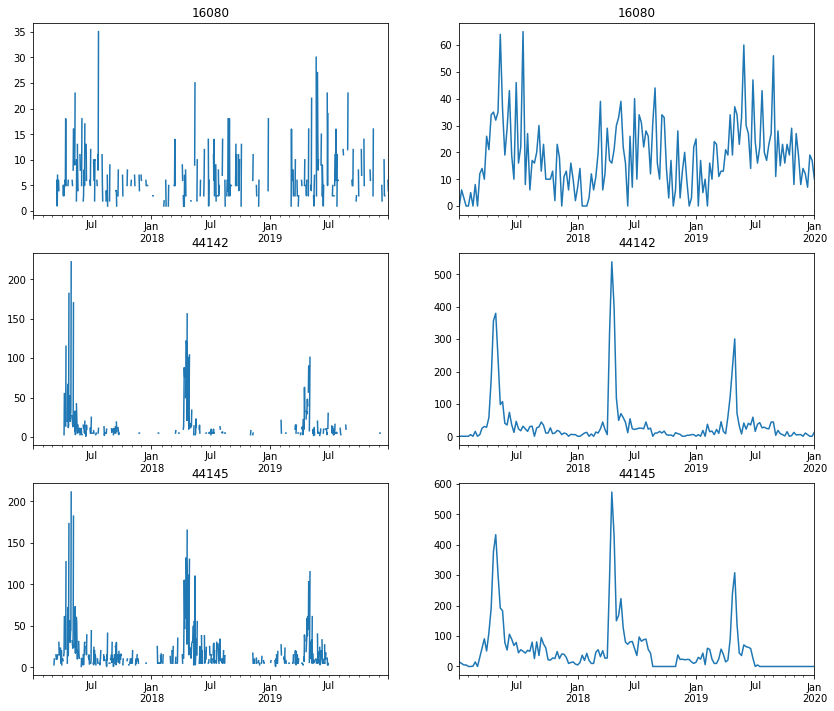

In [10]:
items = [16080, 44142, 44145]
f, ax = plt.subplots(3, 2, figsize=(14, 3*4))
for k, item in enumerate(items):
    u_producto[item].plot(ax=ax[k, 0], title=item)
    ax[k, 0].set_xlabel("")
    u_producto[item].resample("W").sum().plot(ax=ax[k, 1], title=item)
    ax[k, 1].set_xlabel("")

In [11]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=4)

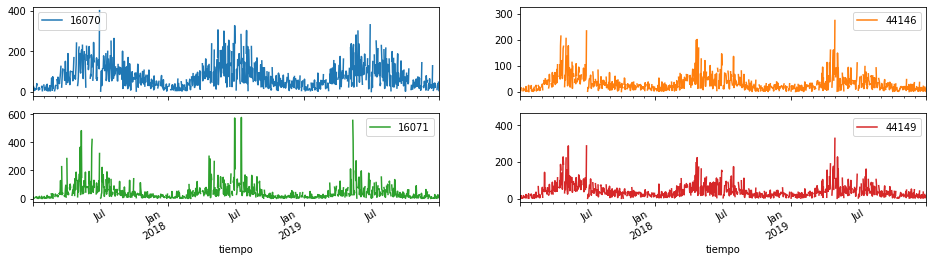

In [12]:
utils.plot_grid(u_producto_forecastable, n_cols=2, figsize=(16, 4))

In [13]:
train, test = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

# Weekly Forecast

In [14]:
item = 44149
y_train = train[item].resample("W").sum()
y_test = test[item].resample("W").sum()

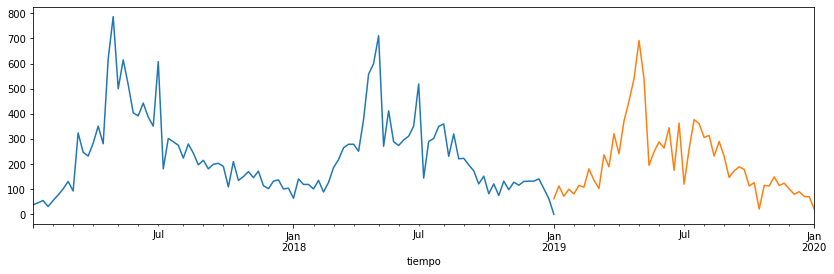

In [15]:
y_train.plot()
y_test.plot()

In [18]:
y_train.index.name = "ds"
y_train.name = "y"

In [34]:
model_prophet = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False, 
    daily_seasonality=False)
model_prophet.fit(y_train.reset_index())
future = model_prophet.make_future_dataframe(periods=52, freq="W")
fcst = model_prophet.predict(future)
fcst = fcst[["ds", "yhat", "yhat_lower", "yhat_upper"]].set_index("ds")

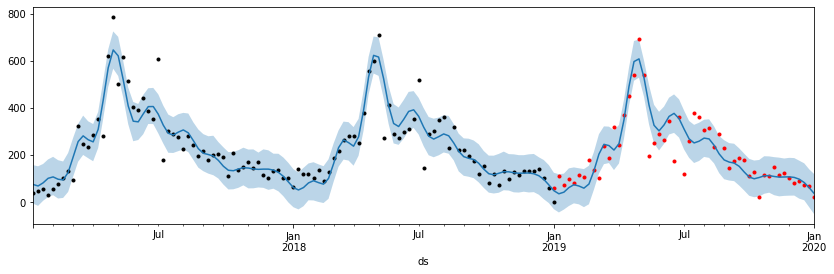

In [35]:
utils.plot_fcst(fcst, train=y_train, test=y_test)

In [38]:
train_w = train.resample("W").sum()

In [45]:
test_w = test.resample("W").sum()

In [39]:
from forecaster import ProphetForecaster

In [54]:
model_prophet = ProphetForecaster(
    use_boxcox=False,
    yearly_seasonality=True,
    country_holidays="AR")

In [55]:
model_prophet.fit(train_w)

Fitting...


4 of 4|###################################################################|100%


{16070: <fbprophet.forecaster.Prophet at 0x13abae76e88>,
 44146: <fbprophet.forecaster.Prophet at 0x13a8140cf88>,
 16071: <fbprophet.forecaster.Prophet at 0x13a82015388>,
 44149: <fbprophet.forecaster.Prophet at 0x13a811eae48>}

In [56]:
fcst_w = model_prophet.predict(52, freq="W")

Forecasting...


4 of 4|###################################################################|100%


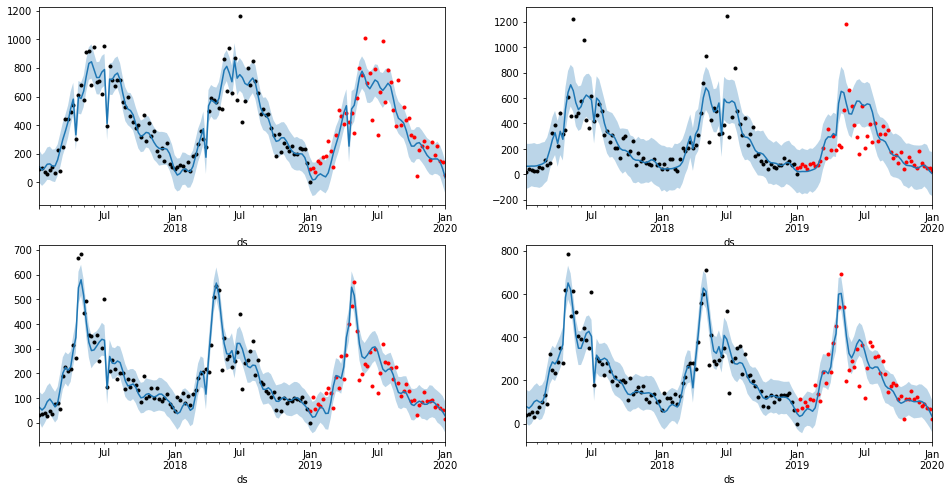

In [57]:
f, axs = plt.subplots(2, 2, figsize=(16, 8))
items = fcst_w.columns.droplevel(1).drop_duplicates()
for item, ax in zip(items, np.ravel(axs)):
    utils.plot_fcst(fcst_w[item], train=train_w[item], test=test_w[item], ax=ax)

In [49]:
fcst_w_yhat = fcst_w.loc[:, pd.IndexSlice[:, "yhat"]].droplevel(1, axis=1)

In [50]:
error = fcst_w_yhat.tail(12) - test_w

In [51]:
error.abs().mean()

16070    56.790324
16071    28.821637
44146    13.946459
44149    19.103943
dtype: float64

In [53]:
error.abs().mean().mean()

29.665590875930086